# Benchmarks SIMD vs Generic implementation (6-Body Solar System)

## Loading packages and functions

In [1]:
using LinearAlgebra, Plots
using OrdinaryDiffEq
using IRKGaussLegendre

include("./utils.jl");



## Definition of the N-body problem

In Nbody.jl below, the following functions are defined: NbodyEnergy(u,Gm), NbodyODE!(du,u,Gm,t), and NbodyODE1!(du,u,Gm,t), where

\begin{equation*}
u = 
\left(\begin{matrix}
q_1  & v_1\\
\vdots & \vdots \\
q_N  & v_N
\end{matrix}
\right) \in \mathbb{R}^{2 \times 3\times N}, \quad
Gm = (G\,  m_1, \ldots,G\,  m_N) \in \mathbb{R}^N.
\end{equation*}

The energy, as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:
\begin{equation*}
\begin{split}
\mathrm{Energy}(q_1,\ldots,q_N,v_1,\ldots,v_N) = 
\frac12 \sum_{i=1}^{N} m_i \, \|v_i\|^2
- G \sum_{1\leq i < j \leq N} \frac{m_i m_j}{\|q_i-q_j\|}.
\end{split}
\end{equation*}


The ODE system of the N-body problem,
as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:
\begin{equation*}
\begin{split}
\frac{d}{dt} q_i &= v_i, \\
\frac{d}{dt} v_i &= G\, 
\sum_{j \neq i} \frac{m_j}{\|q_j-q_i\|^3}\,
(q_j-q_i).
\end{split}
\end{equation*}
This system of ODEs can be written in compact form as
\begin{equation*}
\frac{d u}{dt} = f(t,u,Gm)
\end{equation*}




In [3]:
PATH_ODES="../ODEProblems/"

include(string(PATH_ODES,"Initial6Body.jl"))
include(string(PATH_ODES,"Nbody.jl"));

### Initial value problem: 6-body problem (outer solar system)

We consider $N=6$ bodies of the outer solar system: the Sun, Jupiter, Saturn, Uranus, Neptune and Pluto.
The initial values $u_{00}$ are taken from DE430, Julian day (TDB) 2440400.5 (June 28, 1969). 

In [4]:
u0, Gm, bodylist = Initial6Body(Float64)

q0=u0[:,:,1]
v0=u0[:,:,2]

N = length(Gm)

show(bodylist)
E0=NbodyEnergy(u0,Gm)

["Sun" "Jupiter" "Saturn" "Uranus" "Neptune" "Pluto"]

-9.522620605966966e-12

In [5]:
# Testing: center of mass of the outer solar system at the origin of coordinates with zero velocity

q0_ = zeros(3)
v0_ = zeros(3)
Gm0_ = 0.
for i in 1:6
    Gmi = Gm[i]
    qi = u0[:,i,1]
    vi = u0[:,i,2]
    q0_ += Gmi*qi
    v0_ += Gmi*vi
    Gm0_ += Gmi
end
(q0_/Gm0_, v0_/Gm0_)

([1.417048569677335e-18, 9.119357686204585e-20, 1.5082339679877506e-19], [1.0942040830907497e-22, -2.709864045560887e-22, 1.6237832716049163e-22])

In [6]:
t0=0.
tF=1e7   #1e9  # days

tspan= (t0,tF)
prob = ODEProblem(NbodyODE!, u0,tspan , Gm);

In [7]:
Jupiter_period = 11.9*365
tF/Jupiter_period

2302.290779325429

In [8]:
year=365.25
tF/year

27378.507871321013

##### <a href="#top">Back to the top</a>

## Integrations

HAM(u0, Gm) = -9.522620605966966e-12
,400.0,450.0,500.0,550.0,600.0,650.0,700.0,750.0,800.0,850.0,900.0,950.0,1000.0

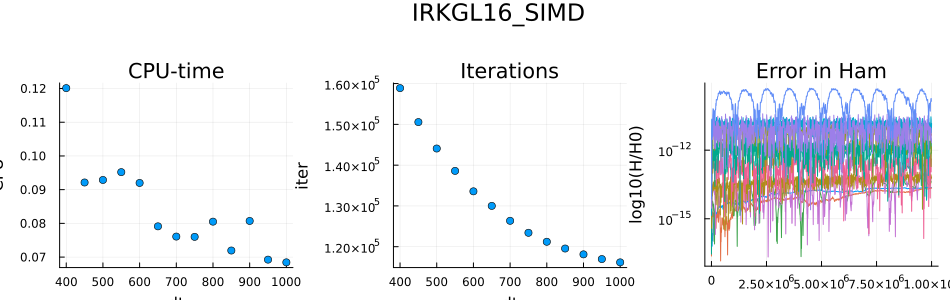

,400.0,450.0,500.0,550.0,600.0,650.0,700.0,750.0,800.0,850.0,900.0,950.0,1000.0

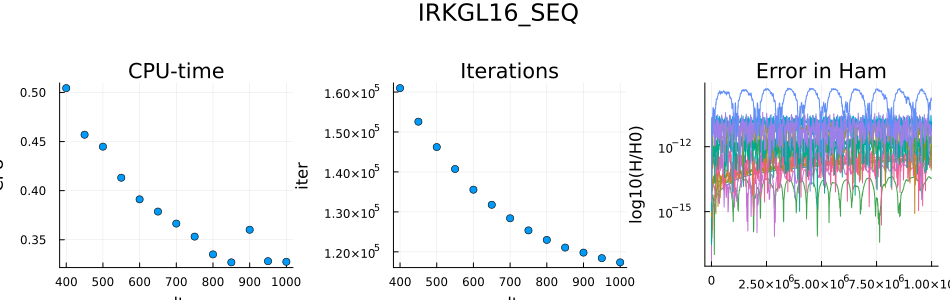

,400.0,450.0,500.0,550.0,600.0,650.0,700.0,750.0,800.0,850.0,900.0,950.0,1000.0

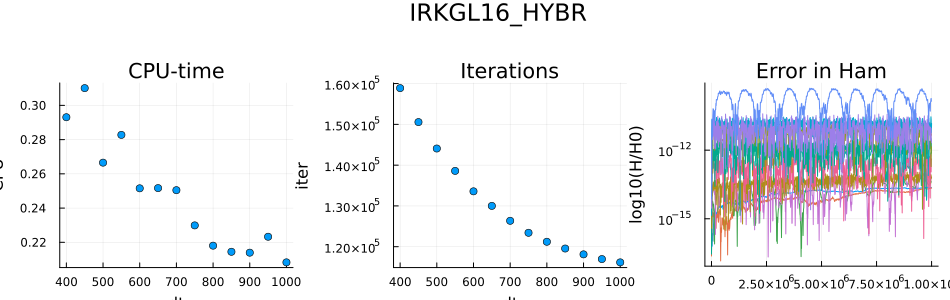

In [9]:
HAM=NbodyEnergy
@show(HAM(u0,Gm))

ddt0=collect(400.:50:1000)
#ddt0=[100.]

alg_simd=IRKGL16(simd=true, fseq=false, second_order_ode=true)
sols_simd,retcodes_simd,iters_simd,cpus_simd,MaxΔHglobal_simd,MaxΔHlocal_simd=
run_many_NbodyIRKGL(alg_simd,ddt0, tspan, u0, Gm, HAM; simdB=true, adaptiveB=false)
fig=plots_NbodyIRKGL("IRKGL16_SIMD",ddt0,u0, Gm,HAM,sols_simd,iters_simd,cpus_simd,MaxΔHlocal_simd)
display(fig)
#
alg_seq=IRKGL16(simd=false, second_order_ode=true)
sols_seq,retcodes_seq,iters_seq,cpus_seq, MaxΔHglobal_seq, MaxΔHlocal_seq=
run_many_NbodyIRKGL(alg_seq, ddt0, tspan, u0, Gm, HAM; simdB=false, adaptiveB=false)
fig=plots_NbodyIRKGL("IRKGL16_SEQ",ddt0,u0, Gm, HAM,sols_seq,iters_seq,cpus_seq,MaxΔHlocal_seq)
display(fig)
#
alg_hybr=IRKGL16(simd=true, fseq=true, second_order_ode=true)
sols_hybr,retcodes_hybr,iters_hybr,cpus_hybr,MaxΔHglobal_hybr,MaxΔHlocal_hybr=
run_many_NbodyIRKGL(alg_hybr,ddt0, tspan, u0, Gm, HAM; simdB=true, adaptiveB=false)
fig=plots_NbodyIRKGL("IRKGL16_HYBR",ddt0,u0, Gm,HAM,sols_hybr,iters_hybr,cpus_hybr,MaxΔHlocal_hybr)
display(fig)

# Work-precision diagrams

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/HX80C/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/HX80C/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/HX80C/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/HX80C/src/ticks.jl:194


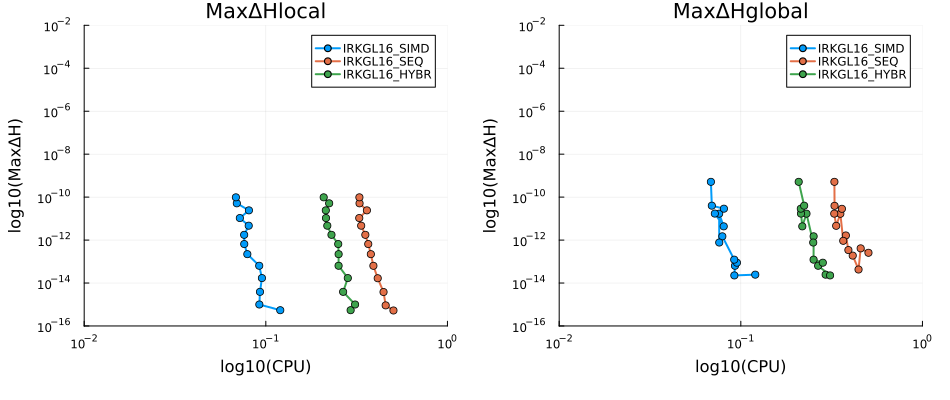

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/HX80C/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/HX80C/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/HX80C/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/HX80C/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/HX80C/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/HX80C/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/HX80C/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/HX80C/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/HX80C/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/HX80C/src/ticks.jl:194


In [12]:
yrange=(1e-16, 1e-2)
xrange=(1e-2,1e0)
pl1=plot( cpus_simd , MaxΔHlocal_simd, scale=:log10,
          markershape=:circle, lw=2,
          ylimits=yrange, xlimits=xrange,
          title="MaxΔHlocal", xlabel="log10(CPU)", ylabel="log10(MaxΔH)", label="IRKGL16_SIMD")
plot!(pl1, cpus_seq , MaxΔHlocal_seq, 
      markershape=:circle, lw=2,
      scale=:log10, xlabel="log10(CPU)", ylabel="log10(MaxΔH)", label="IRKGL16_SEQ")
plot!(pl1, cpus_hybr , MaxΔHlocal_hybr, 
      markershape=:circle, lw=2,
      scale=:log10, xlabel="log10(CPU)", ylabel="log10(MaxΔH)", label="IRKGL16_HYBR")


pl2=plot( cpus_simd , MaxΔHglobal_simd, scale=:log10,
         markershape=:circle, lw=2,
         ylimits=yrange, xlimits=xrange,
         title="MaxΔHglobal", xlabel="log10(CPU)", ylabel="log10(MaxΔH)", label="IRKGL16_SIMD")

plot!(pl2, cpus_seq , MaxΔHglobal_seq,
     markershape=:circle, lw=2,
           scale=:log10, xlabel="log10(CPU)", ylabel="log10(MaxΔH)", label="IRKGL16_SEQ")

plot!(pl2, cpus_hybr , MaxΔHglobal_hybr,
     markershape=:circle, lw=2,
           scale=:log10, xlabel="log10(CPU)", ylabel="log10(MaxΔH)", label="IRKGL16_HYBR")

plot(pl1,pl2, layout=(1,2), size=(950,400),
        bottom_margin=10Plots.mm,
    left_margin=5Plots.mm, right_margin=5Plots.mm)

In [11]:
#savefig("./WorkPrecisionDiagram-with-1-11-2-version(NEW).png")